In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import logging

In [2]:
# logging level: NOTSET, DEBUG, INFO, WARNING, ERROR, CRITICAL
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# 0. Problem setting Forcasting monthly sales for tractors

* All steps together in a [Word file](https://tanthiamhuat.files.wordpress.com/2015/12/step-by-step-guide-to-forecasting-through-arima-modeling.pdf).

* Example code solved with [Jupyter Notebook in Python](http://ucanalytics.com/blogs/wp-content/uploads/2017/08/ARIMA-TimeSeries-Analysis-of-Tractor-Sales.html).

* Original code on ucanalytics.com: [part 1](http://ucanalytics.com/blogs/forecasting-time-series-analysis-manufacturing-case-study-example-part-1/), [part 2](http://ucanalytics.com/blogs/time-series-decomposition-manufacturing-case-study-example-part-2/), [part 3](http://ucanalytics.com/blogs/step-by-step-graphic-guide-to-forecasting-through-arima-modeling-in-r-manufacturing-case-study-example), [part 4](http://ucanalytics.com/blogs/step-by-step-graphic-guide-to-forecasting-through-arima-modeling-in-r-manufacturing-case-study-example/), and [part 5](http://ucanalytics.com/blogs/how-effective-is-my-marketing-budget-regression-with-arima-errors-arimax-case-study-example-part-5/). 

* Tutorials on time series: [1](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/), [2](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3), [3](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3), [4](https://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016), 
    

# 1. Load data

# 1.1. Load directly from an online .csv

In [3]:
from io import StringIO
import requests

url = 'http://www.ucanalytics.com/blogs/wp-content/uploads/2015/06/Tractor-Sales.csv'
s = requests.get(url).text
df = pd.read_csv(StringIO(s))
df

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203
...,...,...
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519


# 1.2 Load from a local csv

In [4]:
input_file_name = "./Tractor-Sales.csv"
df = pd.read_csv(input_file_name)
df

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203
...,...,...
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519


# 2. Data cleaning and preparation

## 2.1 Clean missing data

Check for missing data

In [5]:
for column in df.columns:
    print(f"{column}, {sum(df[column].isnull())}")

Month-Year, 0
Number of Tractor Sold, 0


No missing data, but that if it were needed, we would remove the nan values

In [6]:
df = df.dropna()

Check again for missing data

In [7]:
for column in df.columns:
    print(f"{column}, {sum(df[column].isnull())}")

Month-Year, 0
Number of Tractor Sold, 0


## 2.2 Create a time series data frame

By creating columns related to date time

In [8]:
df.dtypes

Month-Year                object
Number of Tractor Sold     int64
dtype: object

Type object is a string. 

2.2.1 Create the column by hand, assuming the 28th of the month.

In [9]:
def get_date(x):
    l = x.split("-")
    return f"20{l[1]}-{l[0]}-28"

In [10]:
df["date"] = df["Month-Year"].map(lambda x: get_date(x))
df["datetime"] = pd.to_datetime(df["date"])
df

,Month-Year,Number of Tractor Sold,date,datetime
0,Jan-03,141,2003-Jan-28,2003-01-28
1,Feb-03,157,2003-Feb-28,2003-02-28
2,Mar-03,185,2003-Mar-28,2003-03-28
3,Apr-03,199,2003-Apr-28,2003-04-28
4,May-03,203,2003-May-28,2003-05-28
...,...,...,...,...
139,Aug-14,848,2014-Aug-28,2014-08-28
140,Sep-14,640,2014-Sep-28,2014-09-28
141,Oct-14,581,2014-Oct-28,2014-10-28
142,Nov-14,519,2014-Nov-28,2014-11-28


There is an aumamatic way to do that with a Pandas method, assuming the rows are already ordered by time with one entry per month. There are two options for frequency:

* freq = "M" -> the date is set at the end of the month
* freq = "MS" -> the date is set at the start of the month

So there is an advantage over the method by hand from above, as it already knows for each month how many days there are and sets the count at the end of the month.

In [11]:
df["datetime"] = pd.date_range(start = "2003-01-28", freq = "M", periods = len(df))
df

,Month-Year,Number of Tractor Sold,date,datetime
0,Jan-03,141,2003-Jan-28,2003-01-31
1,Feb-03,157,2003-Feb-28,2003-02-28
2,Mar-03,185,2003-Mar-28,2003-03-31
3,Apr-03,199,2003-Apr-28,2003-04-30
4,May-03,203,2003-May-28,2003-05-31
...,...,...,...,...
139,Aug-14,848,2014-Aug-28,2014-08-31
140,Sep-14,640,2014-Sep-28,2014-09-30
141,Oct-14,581,2014-Oct-28,2014-10-31
142,Nov-14,519,2014-Nov-28,2014-11-30


Check datetime has indeed the datetime64 type. 

In [12]:
df.dtypes

Month-Year                        object
Number of Tractor Sold             int64
date                              object
datetime                  datetime64[ns]
dtype: object

Add as columns year and month as numbers (numerical variables).

In [13]:
df["year"] = df.datetime.dt.year
df["month"] = df.datetime.dt.month
df

,Month-Year,Number of Tractor Sold,date,datetime,year,month
0,Jan-03,141,2003-Jan-28,2003-01-31,2003,1
1,Feb-03,157,2003-Feb-28,2003-02-28,2003,2
2,Mar-03,185,2003-Mar-28,2003-03-31,2003,3
3,Apr-03,199,2003-Apr-28,2003-04-30,2003,4
4,May-03,203,2003-May-28,2003-05-31,2003,5
...,...,...,...,...,...,...
139,Aug-14,848,2014-Aug-28,2014-08-31,2014,8
140,Sep-14,640,2014-Sep-28,2014-09-30,2014,9
141,Oct-14,581,2014-Oct-28,2014-10-31,2014,10
142,Nov-14,519,2014-Nov-28,2014-11-30,2014,11


Add as column the month name as string (categorical variable).

In [14]:
import calendar
df["month_name"] = df.month.map(lambda x: calendar.month_abbr[x])
df

,Month-Year,Number of Tractor Sold,date,datetime,year,month,month_name
0,Jan-03,141,2003-Jan-28,2003-01-31,2003,1,Jan
1,Feb-03,157,2003-Feb-28,2003-02-28,2003,2,Feb
2,Mar-03,185,2003-Mar-28,2003-03-31,2003,3,Mar
3,Apr-03,199,2003-Apr-28,2003-04-30,2003,4,Apr
4,May-03,203,2003-May-28,2003-05-31,2003,5,May
...,...,...,...,...,...,...,...
139,Aug-14,848,2014-Aug-28,2014-08-31,2014,8,Aug
140,Sep-14,640,2014-Sep-28,2014-09-30,2014,9,Sep
141,Oct-14,581,2014-Oct-28,2014-10-31,2014,10,Oct
142,Nov-14,519,2014-Nov-28,2014-11-30,2014,11,Nov


Rename the column of the number of tractors sold to y, for faster coding in the future.

In [15]:
df.rename(columns = {"Number of Tractor Sold": "y"}, inplace = True)
df

,Month-Year,y,date,datetime,year,month,month_name
0,Jan-03,141,2003-Jan-28,2003-01-31,2003,1,Jan
1,Feb-03,157,2003-Feb-28,2003-02-28,2003,2,Feb
2,Mar-03,185,2003-Mar-28,2003-03-31,2003,3,Mar
3,Apr-03,199,2003-Apr-28,2003-04-30,2003,4,Apr
4,May-03,203,2003-May-28,2003-05-31,2003,5,May
...,...,...,...,...,...,...,...
139,Aug-14,848,2014-Aug-28,2014-08-31,2014,8,Aug
140,Sep-14,640,2014-Sep-28,2014-09-30,2014,9,Sep
141,Oct-14,581,2014-Oct-28,2014-10-31,2014,10,Oct
142,Nov-14,519,2014-Nov-28,2014-11-30,2014,11,Nov


Keep only the subset of interesting variables and change the order as well if needed.

In [16]:
df = df.loc[:, ["datetime", "year", "month_name", "y"]]
df

,datetime,year,month_name,y
0,2003-01-31,2003,Jan,141
1,2003-02-28,2003,Feb,157
2,2003-03-31,2003,Mar,185
3,2003-04-30,2003,Apr,199
4,2003-05-31,2003,May,203
...,...,...,...,...
139,2014-08-31,2014,Aug,848
140,2014-09-30,2014,Sep,640
141,2014-10-31,2014,Oct,581
142,2014-11-30,2014,Nov,519


Set the datetime as index, so that the dataframe is treated like a time series.

In [17]:
df.set_index("datetime", inplace = True)
df

,year,month_name,y
datetime,,,
2003-01-31,2003,Jan,141
2003-02-28,2003,Feb,157
2003-03-31,2003,Mar,185
2003-04-30,2003,Apr,199
2003-05-31,2003,May,203
...,...,...,...
2014-08-31,2014,Aug,848
2014-09-30,2014,Sep,640
2014-10-31,2014,Oct,581


# 3. Time series analysis

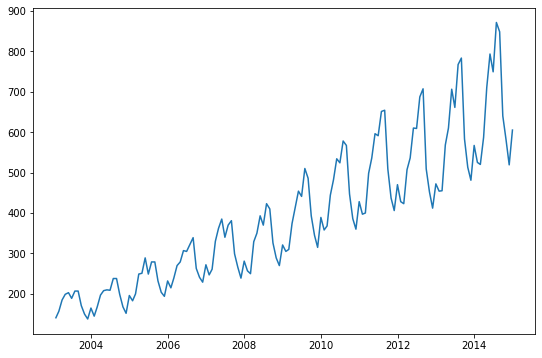

In [18]:
plt.figure(figsize = (9,6))
plt.plot(df.y)
# plt.plot(df.datetime, df.y) # this would be needed if we had not set the index of the df to be datetime

The typical way to understand a time series and later predict is to decompose into three independent components that ar ethen summed, or multiplied:

* trend (across years, a linear fit)
* seasonality (across months or seasons, a sine wave fit maybe)
* irregular remainder (ideally white noise)

If the data contains many years, we can use in between trend and seasonality a fourth component, cycle, of patterns that repeat typically every 5-7 years.

* trend (across years, a linear fit)
* seasonality (across months or seasons, a sine wave fit maybe)
* cycle (trends across many years, usually 5-7 years)
* irregular remainder (ideally white noise)

In our data a cycle is non existent. 

The key idea is that it is much easier to predict each component individually.

The prediction p(t) = Trend(t) * Seasonality(t) * Remainder (t)

## 3.2 Trend

There are two steps: 

* 1. Explore visually with a rolling average what is the frequncy that gives a linear trend
* 2. Perform a statistic test to disprove the null hypothesis that there is no trend

### 3.2.1 Rolling averages

Let's study the moving averages with 4, 6, 8, 12 months. The rolling average is computed directly with a Pandas function.

In [19]:
def plot_once(ax, df, column, nbRolling):
    ax.plot(df.index, df[column], label='Original')
    ax.plot(df.index, df[column].rolling(window=nbRolling).mean(), label = f"{str(nbRolling).zfill(2)}-Months Rolling Mean")
    ax.plot(df.index, df[column].rolling(window=nbRolling).std(), label = f"{str(nbRolling).zfill(2)}-Months Rolling Std")
    ax.set_xlabel("Years")
    ax.set_ylabel("Number of Tractors Sold")
    ax.set_title(f"{str(nbRolling).zfill(2)}-Months Moving Average")
    ax.legend(loc='best')

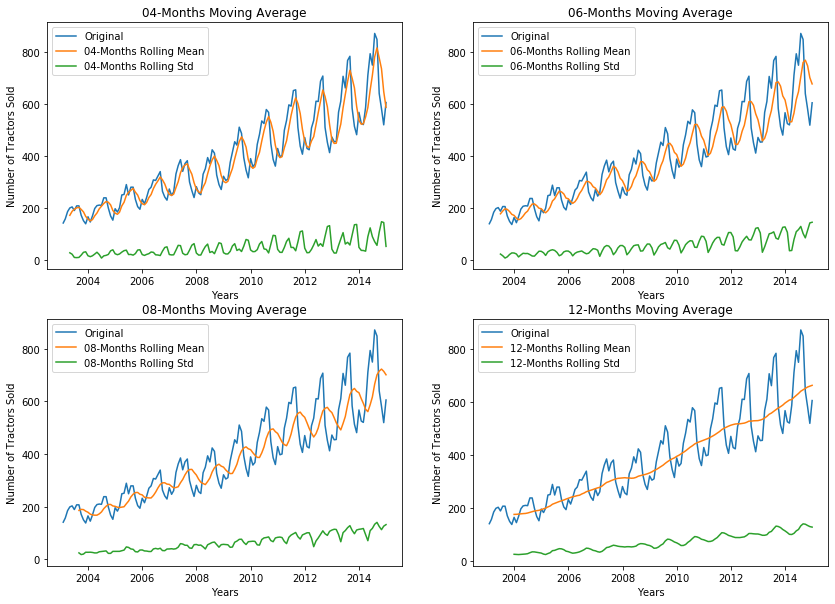

In [20]:
fig, axes = plt.subplots(2, 2, figsize = (14, 10), sharey=False, sharex=False)
column = "y"
plot_once(axes[0][0], df, column, 4)
plot_once(axes[0][1], df, column, 6)
plot_once(axes[1][0], df, column, 8)
plot_once(axes[1][1], df, column, 12)

### 3.2.2 Dickey-Fuller Test

Null Hypothesis: there is a trend, or the time series is non-stationary.
    
We calculate a test statistic and a confidence interval, we compare with a critical value. If the test statistic is less than the critical value, we can reject the null hypothesis and say the series is stationary.

In [21]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

In [22]:
df_test = adfuller(df.y, autolag='AIC')
df_test

(1.1088250591467337,
 0.9952912415248419,
 14,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 1082.5357724796872)

In [23]:
df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
df_output

Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
dtype: float64

In [24]:
for key, value in df_test[4].items():
    df_output[f"Critical Value ({key})"] = value
df_output

Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64

In [25]:
logging.info("Results of Dickey-Fuller Test:")
logging.info(df_output)

INFO:root:Results of Dickey-Fuller Test:
INFO:root:Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


The test statistics is not smaller than the critical values, we we can not reject the null hypothesis, so there is a trend. 

The rms of the rolling average is almost constant in time. But the mean of the rolling average is clearly increasing, so there is a trend.

## 3.3 Seasonality

First let's overlay all years to see how the number of orders varies every month. 

In [26]:
df

,year,month_name,y
datetime,,,
2003-01-31,2003,Jan,141
2003-02-28,2003,Feb,157
2003-03-31,2003,Mar,185
2003-04-30,2003,Apr,199
2003-05-31,2003,May,203
...,...,...,...
2014-08-31,2014,Aug,848
2014-09-30,2014,Sep,640
2014-10-31,2014,Oct,581


### 3.3.1 Done by hand

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

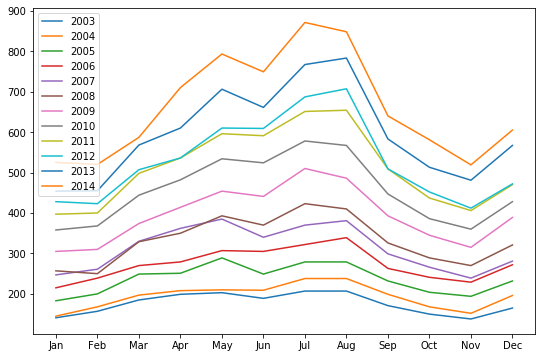

In [27]:
fig, ax = plt.subplots(figsize = (9,6))
for year in range(2003, 2015):
    df_current = df.loc[(df.index >= pd.to_datetime(f"{year}-Jan-01")) & (df.index <= pd.to_datetime(f"{year}-Dec-31"))] 
    ax.plot(df_current.month_name, df_current.y, label = f"{year}")
plt.legend(loc = "best")

### 3.3.2 Done by Pandas 

In [28]:
monthly_sales_data = pd.pivot_table(df, values = "y", columns = "year", index = "month_name")
monthly_sales_data

year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
month_name,,,,,,,,,,,,
Apr,199,208,251,279,362,350,414,482,536,536,610,710
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Dec,165,196,232,272,281,321,389,428,470,472,567,605
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Mar,185,197,249,270,330,329,374,444,498,507,568,587
May,203,210,289,307,385,393,454,534,596,610,706,793


The months used as index appear in alphabetical order, so we want to reindex with the months in the chronological order.

In [29]:
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
month_name,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


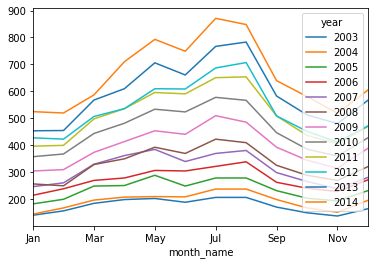

In [30]:
monthly_sales_data.plot()

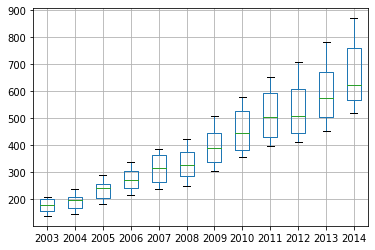

In [31]:
# https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
# edges are minimum (quartile of 0%) and maximum (quartile of 100%)
# blue is the first quartile (25%) and last quartile (75%)
# green is the median (50%)
monthly_sales_data.boxplot()

In [32]:
yearly_sales_data = pd.pivot_table(df, values = "y", columns = "month_name", index = "year")
yearly_sales_data

month_name,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
year,,,,,,,,,,,,
2003,199,207,165,157,141,207,189,185,203,138,150,171
2004,208,238,196,168,145,238,209,197,210,152,168,199
2005,251,279,232,200,183,279,249,249,289,194,204,232
2006,279,339,272,239,215,322,305,270,307,229,241,263
2007,362,381,281,261,247,370,340,330,385,239,266,299
2008,350,410,321,250,257,423,370,329,393,270,289,326
2009,414,486,389,310,305,510,441,374,454,315,345,393
2010,482,567,428,368,358,578,524,444,534,360,386,447
2011,536,654,470,400,397,651,591,498,596,406,437,509


The months are shown in alphabetical order, so let's re-order then in the chronological order. 

In [33]:
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

month_name,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


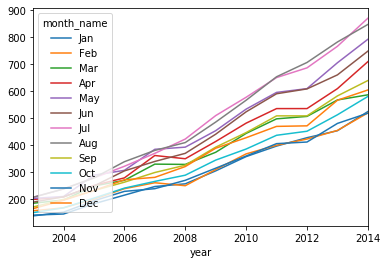

In [34]:
yearly_sales_data.plot()

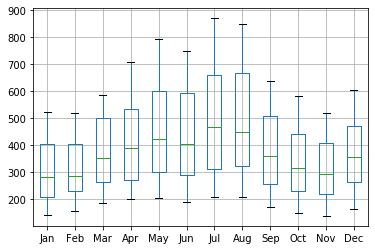

In [35]:
# https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
# edges are minimum (quartile of 0%) and maximum (quartile of 100%)
# blue is the first quartile (25%) and last quartile (75%)
# green is the median (50%)
yearly_sales_data.boxplot()

## 3.4 Remainder

The remaineder is what remains when we take off first the trend, then the seasonality. 

We can use either a multiplication, or an addition to obtain the total predictions:

* Y(t) = Trend(t) * Seasonality(t) * Remainder(t)
* Y(t) = Trend(t) + Seasonality(t) + Remainder(t)

The results are usually the same.

But be careful that this works on really clean data, like here. In real life this does not work that well, and more advanced models, like Holt-Winters seasonal method or ARIMA models are used.

## 3.5 Decomposition



In [36]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

### 3.5.1 Decomposition via multiplication

It is done for us by the statistical model library statsmodels

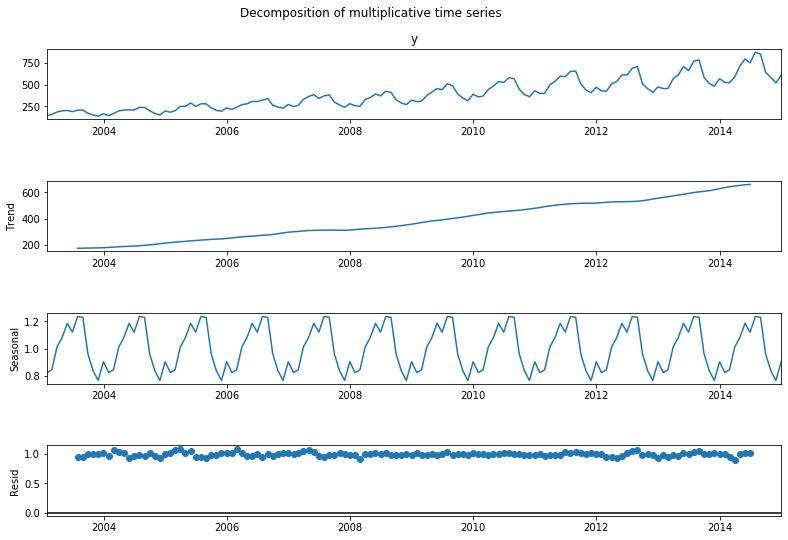

In [37]:
decomposition = sm.tsa.seasonal_decompose(df.y, model='multiplicative')
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

To calculate the three components:

* 1. We fit a line (Linear Regression).

* 2. We divide y(t)/y1(t) to obtain Sesonality(t) * Residual(t). If indeed we removed the year to year trend, the values should be similar for the months across years, so we take their mean. That gives Seasonality(t), or y2(t). 

* 3. We divide (y(t)/y1(t)) / y2(t)) to obtain the Remainder(t), or y3(t).

We can predict for new values y(t) = y1(t) * y2(t) * y3(t).

### 3.5.2 Decomposition via addition

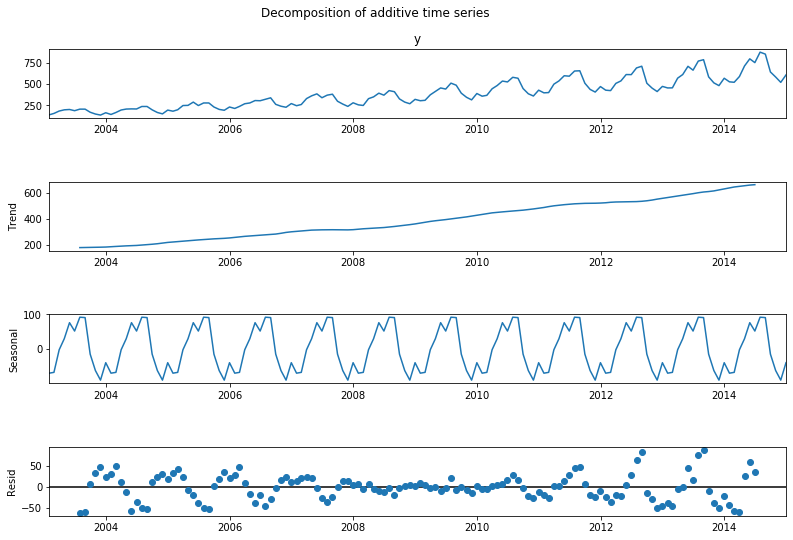

In [38]:
decomposition = sm.tsa.seasonal_decompose(df.y, model='additive')
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of additive time series')
plt.show()

To calculate the three components:

* 1. We fit a line (Linear Regression).

* 2. We subtract y(t)-y1(t) to obtain Sesonality(t) + Residual(t). If indeed we removed the year to year trend, the values should be similar for the months across years, so we take their mean. That gives Seasonality(t), or y2(t). 

* 3. We subract (y(t) - y1(t)) - y2(t)) to obtain the Remainder(t), or y3(t).

We can predict for new values y(t) = y1(t) + y2(t) + y3(t).

### 3.5.3 Calculate components

We choose a hybrid method where y(t) = y1(t) * y2(t) + y3(t), given that if y3 is also a multiplication factor and not well modelled as wide noise it impacts percentage-wise more, but in absolute value it affects less. 

Via a linear regression fit

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
df

,year,month_name,y
datetime,,,
2003-01-31,2003,Jan,141
2003-02-28,2003,Feb,157
2003-03-31,2003,Mar,185
2003-04-30,2003,Apr,199
2003-05-31,2003,May,203
...,...,...,...
2014-08-31,2014,Aug,848
2014-09-30,2014,Sep,640
2014-10-31,2014,Oct,581


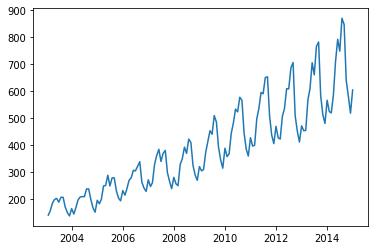

In [41]:
plt.plot(df.y)

In [42]:
year_start = 2003
year_end = 2014 # inclusive
nb_months_per_year = 12
X = np.array([i for i in range((year_end-year_start+1)*nb_months_per_year)])
X = X.reshape(X.shape[0], 1)
X

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

In [43]:
y = df.y.values
lr = LinearRegression()
regression = lr.fit(X, y)
y1 = lr.predict(X)
df["y1"] = y1
df

,year,month_name,y,y1
datetime,,,,
2003-01-31,2003,Jan,141,126.362261
2003-02-28,2003,Feb,157,130.045228
2003-03-31,2003,Mar,185,133.728196
2003-04-30,2003,Apr,199,137.411163
2003-05-31,2003,May,203,141.094131
...,...,...,...,...
2014-08-31,2014,Aug,848,638.294758
2014-09-30,2014,Sep,640,641.977726
2014-10-31,2014,Oct,581,645.660693


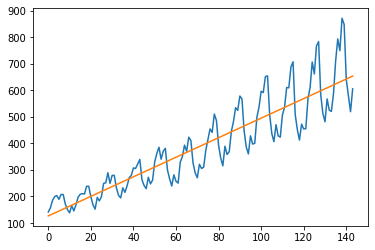

In [44]:
plt.plot(y)
plt.plot(y1)

In [45]:
df["y_div_y1"] = df.y / df.y1
df

,year,month_name,y,y1,y_div_y1
datetime,,,,,
2003-01-31,2003,Jan,141,126.362261,1.115839
2003-02-28,2003,Feb,157,130.045228,1.207272
2003-03-31,2003,Mar,185,133.728196,1.383403
2003-04-30,2003,Apr,199,137.411163,1.448208
2003-05-31,2003,May,203,141.094131,1.438756
...,...,...,...,...,...
2014-08-31,2014,Aug,848,638.294758,1.328540
2014-09-30,2014,Sep,640,641.977726,0.996919
2014-10-31,2014,Oct,581,645.660693,0.899853


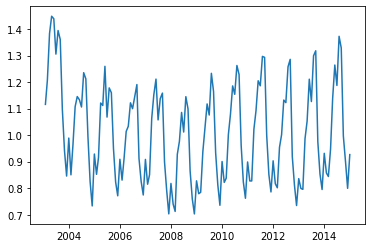

In [46]:
plt.plot(df.y_div_y1)

In [47]:
monthly_sales_data = pd.pivot_table(df, values = "y_div_y1", columns = "year", index = "month_name")
monthly_sales_data

year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
month_name,,,,,,,,,,,,
Apr,1.448208,1.145332,1.111591,1.033341,1.152156,0.976592,1.028355,1.078830,1.091703,1.001548,1.052873,1.138618
Aug,1.360562,1.212191,1.159918,1.190602,1.158317,1.098839,1.164583,1.228570,1.293237,1.285680,1.317962,1.328540
Dec,0.988765,0.928600,0.908855,0.908296,0.817675,0.827633,0.900362,0.898699,0.903082,0.835938,0.931293,0.926455
Feb,1.207272,0.964183,0.915598,0.910018,0.850640,0.712203,0.784375,0.837478,0.827113,0.801431,0.795453,0.843886
Jan,1.115839,0.850151,0.852140,0.830279,0.814792,0.739908,0.778983,0.821607,0.827209,0.816603,0.798848,0.857123
Jul,1.394314,1.235365,1.177954,1.145716,1.137613,1.144982,1.232975,1.262479,1.296748,1.257734,1.299084,1.372493
Jun,1.305455,1.105980,1.067898,1.099638,1.057347,1.011606,1.075739,1.153813,1.185933,1.122503,1.126577,1.187139
Mar,1.383403,1.107216,1.121019,1.013837,1.062766,0.927528,0.937574,1.002037,1.021972,0.953924,0.986652,0.946958
May,1.438756,1.133360,1.259340,1.121744,1.211162,1.085419,1.117490,1.185446,1.204870,1.132031,1.210873,1.264257


Let's create the average across years by giving up the columns variable. 

In [48]:
monthly_sales_data = pd.pivot_table(df, values = "y_div_y1", index = "month_name", aggfunc = np.mean)
monthly_sales_data

,y_div_y1
month_name,
Apr,1.104929
Aug,1.233250
Dec,0.897971
Feb,0.870804
Jan,0.841957
Jul,1.246455
Jun,1.124969
Mar,1.038740
May,1.197062


In [49]:
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

,y_div_y1
month_name,
Jan,0.841957
Feb,0.870804
Mar,1.038740
Apr,1.104929
May,1.197062
Jun,1.124969
Jul,1.246455
Aug,1.233250
Sep,0.958627


In [50]:
monthly_sales_data.y_div_y1.to_dict()

{'Jan': 0.841956950354513,
 'Feb': 0.870804271073616,
 'Mar': 1.0387403756390765,
 'Apr': 1.1049288502363763,
 'May': 1.1970622768626662,
 'Jun': 1.1249688903139947,
 'Jul': 1.246454699650962,
 'Aug': 1.2332500293676512,
 'Sep': 0.9586266139863486,
 'Oct': 0.8345697749435114,
 'Nov': 0.7617598805059425,
 'Dec': 0.897971063522892}

In [51]:
df["y2"] = df.month_name.map(monthly_sales_data.y_div_y1)
df

,year,month_name,y,y1,y_div_y1,y2
datetime,,,,,,
2003-01-31,2003,Jan,141,126.362261,1.115839,0.841957
2003-02-28,2003,Feb,157,130.045228,1.207272,0.870804
2003-03-31,2003,Mar,185,133.728196,1.383403,1.038740
2003-04-30,2003,Apr,199,137.411163,1.448208,1.104929
2003-05-31,2003,May,203,141.094131,1.438756,1.197062
...,...,...,...,...,...,...
2014-08-31,2014,Aug,848,638.294758,1.328540,1.233250
2014-09-30,2014,Sep,640,641.977726,0.996919,0.958627
2014-10-31,2014,Oct,581,645.660693,0.899853,0.834570


In [52]:
df["y1_times_y2"] = df.y1 * df.y2
df

,year,month_name,y,y1,y_div_y1,y2,y1_times_y2
datetime,,,,,,,
2003-01-31,2003,Jan,141,126.362261,1.115839,0.841957,106.391584
2003-02-28,2003,Feb,157,130.045228,1.207272,0.870804,113.243940
2003-03-31,2003,Mar,185,133.728196,1.383403,1.038740,138.908876
2003-04-30,2003,Apr,199,137.411163,1.448208,1.104929,151.829559
2003-05-31,2003,May,203,141.094131,1.438756,1.197062,168.898462
...,...,...,...,...,...,...,...
2014-08-31,2014,Aug,848,638.294758,1.328540,1.233250,787.177029
2014-09-30,2014,Sep,640,641.977726,0.996919,0.958627,615.416933
2014-10-31,2014,Oct,581,645.660693,0.899853,0.834570,538.848899


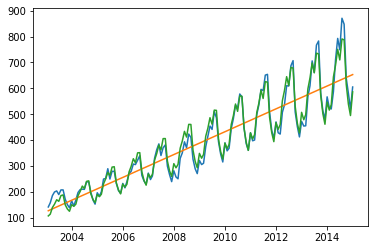

In [53]:
plt.plot(df.y)
plt.plot(df.y1)
plt.plot(df.y1_times_y2)

In [54]:
df["y3"] = df.y - df.y1_times_y2
df

,year,month_name,y,y1,y_div_y1,y2,y1_times_y2,y3
datetime,,,,,,,,
2003-01-31,2003,Jan,141,126.362261,1.115839,0.841957,106.391584,34.608416
2003-02-28,2003,Feb,157,130.045228,1.207272,0.870804,113.243940,43.756060
2003-03-31,2003,Mar,185,133.728196,1.383403,1.038740,138.908876,46.091124
2003-04-30,2003,Apr,199,137.411163,1.448208,1.104929,151.829559,47.170441
2003-05-31,2003,May,203,141.094131,1.438756,1.197062,168.898462,34.101538
...,...,...,...,...,...,...,...,...
2014-08-31,2014,Aug,848,638.294758,1.328540,1.233250,787.177029,60.822971
2014-09-30,2014,Sep,640,641.977726,0.996919,0.958627,615.416933,24.583067
2014-10-31,2014,Oct,581,645.660693,0.899853,0.834570,538.848899,42.151101


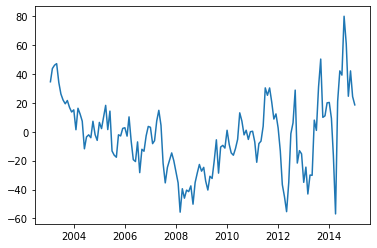

In [55]:
plt.plot(df.y3)

(array([ 4.,  2.,  7., 10.,  8., 13., 13., 18., 19., 13., 10., 10.,  6.,
         2.,  4.,  3.,  0.,  1.,  0.,  1.]),
 array([-56.89430084, -50.05032822, -43.2063556 , -36.36238298,
        -29.51841037, -22.67443775, -15.83046513,  -8.98649252,
         -2.1425199 ,   4.70145272,  11.54542533,  18.38939795,
         25.23337057,  32.07734319,  38.9213158 ,  45.76528842,
         52.60926104,  59.45323365,  66.29720627,  73.14117889,
         79.98515151]),
 <a list of 20 Patch objects>)

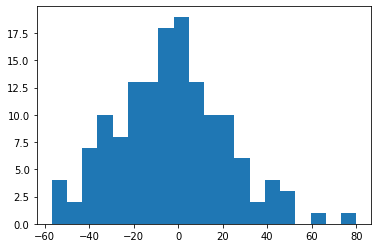

In [56]:
plt.hist(df.y3, bins = 20)

Ideally this should be white noise, that we could model with a gaussian distribution. Let's assume it is the case, so let's get the mean and the standard deviation, and later predict by throwing a random number from a Gaussian distribution with these parameters.

In [57]:
y3_mu = np.mean(df.y3)
y3_std = np.std(df.y3)
logging.info(f"y3_mu={y3_mu:.3f}, y3_std={y3_std:.3f}")

INFO:root:y3_mu=-3.255, y3_std=24.927


In [58]:
df["y1_times_y2_plus_y3"] = df.y1 * df.y2 + df.y3
df

,year,month_name,y,y1,y_div_y1,y2,y1_times_y2,y3,y1_times_y2_plus_y3
datetime,,,,,,,,,
2003-01-31,2003,Jan,141,126.362261,1.115839,0.841957,106.391584,34.608416,141.0
2003-02-28,2003,Feb,157,130.045228,1.207272,0.870804,113.243940,43.756060,157.0
2003-03-31,2003,Mar,185,133.728196,1.383403,1.038740,138.908876,46.091124,185.0
2003-04-30,2003,Apr,199,137.411163,1.448208,1.104929,151.829559,47.170441,199.0
2003-05-31,2003,May,203,141.094131,1.438756,1.197062,168.898462,34.101538,203.0
...,...,...,...,...,...,...,...,...,...
2014-08-31,2014,Aug,848,638.294758,1.328540,1.233250,787.177029,60.822971,848.0
2014-09-30,2014,Sep,640,641.977726,0.996919,0.958627,615.416933,24.583067,640.0
2014-10-31,2014,Oct,581,645.660693,0.899853,0.834570,538.848899,42.151101,581.0


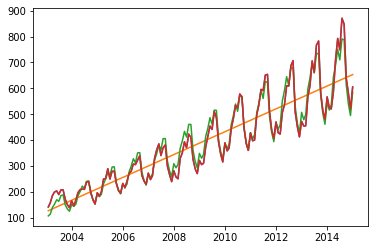

In [59]:
plt.plot(df.y)
plt.plot(df.y1)
plt.plot(df.y1_times_y2)
plt.plot(df.y1_times_y2_plus_y3)

## 3.6 Predict for the next three years

Let's create a new data frame for the following three years

In [60]:
nb_years = 3
nb_months_per_year = 12
df_predict = pd.DataFrame()
df_predict["datetime"] = pd.date_range(start = "2015-01-28", freq = "M", periods = nb_years * nb_months_per_year)
df_predict

,datetime
0,2015-01-31
1,2015-02-28
2,2015-03-31
3,2015-04-30
4,2015-05-31
5,2015-06-30
6,2015-07-31
7,2015-08-31
8,2015-09-30
9,2015-10-31


In [61]:
df_predict["month"] = df_predict.datetime.dt.month
df_predict["month_name"] = df_predict.month.map(lambda x: calendar.month_abbr[x])
df_predict["y"] = 0.0 # dummy value
df_predict.set_index("datetime", inplace = True) # to interpret it as a time series
df_predict

,month,month_name,y
datetime,,,
2015-01-31,1,Jan,0.0
2015-02-28,2,Feb,0.0
2015-03-31,3,Mar,0.0
2015-04-30,4,Apr,0.0
2015-05-31,5,May,0.0
2015-06-30,6,Jun,0.0
2015-07-31,7,Jul,0.0
2015-08-31,8,Aug,0.0
2015-09-30,9,Sep,0.0


In [62]:
X_predict = np.array([i for i in range((year_end-year_start+1)*nb_months_per_year, (year_end-year_start+1+nb_years)*nb_months_per_year, 1)])
display(X_predict.shape)
display(X_predict)
X_predict = X_predict.reshape(X_predict.shape[0], 1)
display(X_predict.shape)
display(X_predict)

(36,)

array([144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179])

(36, 1)

array([[144],
       [145],
       [146],
       [147],
       [148],
       [149],
       [150],
       [151],
       [152],
       [153],
       [154],
       [155],
       [156],
       [157],
       [158],
       [159],
       [160],
       [161],
       [162],
       [163],
       [164],
       [165],
       [166],
       [167],
       [168],
       [169],
       [170],
       [171],
       [172],
       [173],
       [174],
       [175],
       [176],
       [177],
       [178],
       [179]])

In [63]:
df_predict["y1"] = regression.predict(X_predict)
df_predict.head()

,month,month_name,y,y1
datetime,,,,
2015-01-31,1,Jan,0.0,656.709596
2015-02-28,2,Feb,0.0,660.392564
2015-03-31,3,Mar,0.0,664.075531
2015-04-30,4,Apr,0.0,667.758499
2015-05-31,5,May,0.0,671.441466


In [64]:
df_predict["y2"] = df_predict.month_name.map(monthly_sales_data.y_div_y1)
df_predict.head()

,month,month_name,y,y1,y2
datetime,,,,,
2015-01-31,1,Jan,0.0,656.709596,0.841957
2015-02-28,2,Feb,0.0,660.392564,0.870804
2015-03-31,3,Mar,0.0,664.075531,1.038740
2015-04-30,4,Apr,0.0,667.758499,1.104929
2015-05-31,5,May,0.0,671.441466,1.197062


In [65]:
import random
df_predict["y3"] = [random.gauss(y3_mu, y3_std) for i in range(len(df_predict))]
df_predict.head()

,month,month_name,y,y1,y2,y3
datetime,,,,,,
2015-01-31,1,Jan,0.0,656.709596,0.841957,-50.297495
2015-02-28,2,Feb,0.0,660.392564,0.870804,-8.458263
2015-03-31,3,Mar,0.0,664.075531,1.038740,5.984952
2015-04-30,4,Apr,0.0,667.758499,1.104929,-43.879933
2015-05-31,5,May,0.0,671.441466,1.197062,-3.036640


In [66]:
df_predict["y1_times_y2"] = df_predict.y1 * df_predict.y2
df_predict.head()

,month,month_name,y,y1,y2,y3,y1_times_y2
datetime,,,,,,,
2015-01-31,1,Jan,0.0,656.709596,0.841957,-50.297495,552.921209
2015-02-28,2,Feb,0.0,660.392564,0.870804,-8.458263,575.072665
2015-03-31,3,Mar,0.0,664.075531,1.038740,5.984952,689.802067
2015-04-30,4,Apr,0.0,667.758499,1.104929,-43.879933,737.825630
2015-05-31,5,May,0.0,671.441466,1.197062,-3.036640,803.757251


In [67]:
df_predict["y1_times_y2_plus_y3"] = df_predict.y1 * df_predict.y2 + df_predict.y3
df_predict.head()

,month,month_name,y,y1,y2,y3,y1_times_y2,y1_times_y2_plus_y3
datetime,,,,,,,,
2015-01-31,1,Jan,0.0,656.709596,0.841957,-50.297495,552.921209,502.623714
2015-02-28,2,Feb,0.0,660.392564,0.870804,-8.458263,575.072665,566.614402
2015-03-31,3,Mar,0.0,664.075531,1.038740,5.984952,689.802067,695.787018
2015-04-30,4,Apr,0.0,667.758499,1.104929,-43.879933,737.825630,693.945697
2015-05-31,5,May,0.0,671.441466,1.197062,-3.036640,803.757251,800.720611


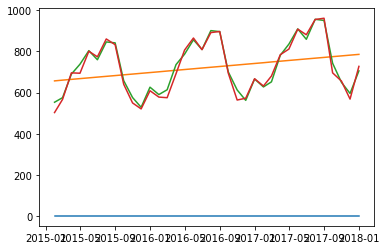

In [68]:
plt.plot(df_predict.y)
plt.plot(df_predict.y1)
plt.plot(df_predict.y1_times_y2)
plt.plot(df_predict.y1_times_y2_plus_y3)

## 3.7 Overlay the original data and the predicted data

In [69]:
df_predict.head()

,month,month_name,y,y1,y2,y3,y1_times_y2,y1_times_y2_plus_y3
datetime,,,,,,,,
2015-01-31,1,Jan,0.0,656.709596,0.841957,-50.297495,552.921209,502.623714
2015-02-28,2,Feb,0.0,660.392564,0.870804,-8.458263,575.072665,566.614402
2015-03-31,3,Mar,0.0,664.075531,1.038740,5.984952,689.802067,695.787018
2015-04-30,4,Apr,0.0,667.758499,1.104929,-43.879933,737.825630,693.945697
2015-05-31,5,May,0.0,671.441466,1.197062,-3.036640,803.757251,800.720611


In [70]:
df_predict_2 = df_predict.loc[:, ["y", "y1", "y1_times_y2", "y1_times_y2_plus_y3"]]
df_predict_2.head()

,y,y1,y1_times_y2,y1_times_y2_plus_y3
datetime,,,,
2015-01-31,0.0,656.709596,552.921209,502.623714
2015-02-28,0.0,660.392564,575.072665,566.614402
2015-03-31,0.0,664.075531,689.802067,695.787018
2015-04-30,0.0,667.758499,737.825630,693.945697
2015-05-31,0.0,671.441466,803.757251,800.720611


In [71]:
df_predict_2.shape

(36, 4)

In [72]:
df.head()

,year,month_name,y,y1,y_div_y1,y2,y1_times_y2,y3,y1_times_y2_plus_y3
datetime,,,,,,,,,
2003-01-31,2003,Jan,141,126.362261,1.115839,0.841957,106.391584,34.608416,141.0
2003-02-28,2003,Feb,157,130.045228,1.207272,0.870804,113.243940,43.756060,157.0
2003-03-31,2003,Mar,185,133.728196,1.383403,1.038740,138.908876,46.091124,185.0
2003-04-30,2003,Apr,199,137.411163,1.448208,1.104929,151.829559,47.170441,199.0
2003-05-31,2003,May,203,141.094131,1.438756,1.197062,168.898462,34.101538,203.0


In [73]:
df_initial_2 = df.loc[:, ["y", "y1", "y1_times_y2", "y1_times_y2_plus_y3"]]
df_initial_2.head()

,y,y1,y1_times_y2,y1_times_y2_plus_y3
datetime,,,,
2003-01-31,141,126.362261,106.391584,141.0
2003-02-28,157,130.045228,113.243940,157.0
2003-03-31,185,133.728196,138.908876,185.0
2003-04-30,199,137.411163,151.829559,199.0
2003-05-31,203,141.094131,168.898462,203.0


In [74]:
df_initial_2.shape

(144, 4)

In [75]:
df_all = pd.concat([df_initial_2, df_predict_2], axis = 0)
df_all

,y,y1,y1_times_y2,y1_times_y2_plus_y3
datetime,,,,
2003-01-31,141.0,126.362261,106.391584,141.000000
2003-02-28,157.0,130.045228,113.243940,157.000000
2003-03-31,185.0,133.728196,138.908876,185.000000
2003-04-30,199.0,137.411163,151.829559,199.000000
2003-05-31,203.0,141.094131,168.898462,203.000000
...,...,...,...,...
2017-08-31,0.0,770.881592,950.689746,961.373945
2017-09-30,0.0,774.564559,742.518201,695.738274
2017-10-31,0.0,778.247527,649.501863,655.676108


In [76]:
df_all.shape

(180, 4)

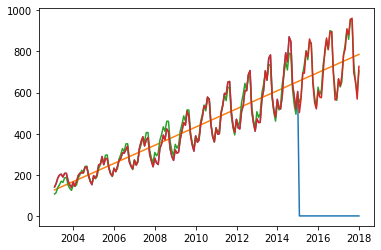

In [77]:
plt.plot(df_all.y)
plt.plot(df_all.y1)
plt.plot(df_all.y1_times_y2)
plt.plot(df_all.y1_times_y2_plus_y3)

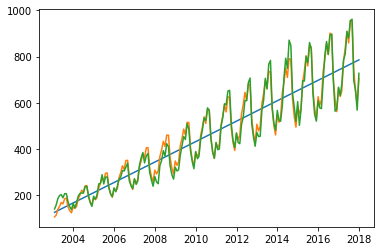

In [78]:
plt.plot(df_all.y1)
plt.plot(df_all.y1_times_y2)
plt.plot(df_all.y1_times_y2_plus_y3)

# 4. ARIMA

In real life this simple decomposition usually does not work that well, and more advanced models are used. 

One is ARIMA. The acronym stands for:
* AR = Auto Regressive
* I = Integrated
* MA = Moving Average

An implementation for this dataset in Python can be found [here](http://ucanalytics.com/blogs/wp-content/uploads/2017/08/ARIMA-TimeSeries-Analysis-of-Tractor-Sales.html). 